# SSCx Dissemination.

We analyze circuits developed under the SSCx Dissemination project.


In [1]:
from collections import OrderedDict
from tqdm import tqdm
from dmt.tk.plotting import Bars, LinePlot, Crosses
from dmt.data.observation import measurement
from dmt.tk.plotting.multi import MultiPlot
from neuro_dmt.models.bluebrain.circuit.geometry import Cuboid
from neuro_dmt.library.users.visood.sscx_dissemination.analyses import *

While using this notebook for development, we might need to reload the adapter:

In [2]:
sscxdiss = SSCxDisseminationCircuit()

In [3]:
sscxdiss.variations

bio0: Not Available
bio1: Not Available
bio2: Not Available
bio3: Not Available
bio4: Not Available
bio5: Not Available
biom: 'Bio_M/20191206'
mock: 'MOCK'

We will need to parameterize our analysis:

In [4]:
spec = AnalysisParameterization()
spec.field_dict

{'morphologies_interneurons': ['BP',
  'BTC',
  'CHC',
  'DB',
  'LBC',
  'NBC',
  'MC',
  'SBC',
  'SSC'],
 'number_cortical_thickness_bins': 50,
 'path_reports': '/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports',
 'sample_size': 100,
 'size_roi': array([50., 50., 50.])}

In [5]:
#circuit_model = sscxdiss.circuit(sscxdiss.variations.mock)
circuit_model = sscxdiss.circuit(sscxdiss.variations.biom)
adapter = sscxdiss.adapter

In [6]:
from importlib import reload
from neuro_dmt.models.bluebrain.circuit.adapter import adapter as ad
from neuro_dmt.models.bluebrain.circuit import model as md
from neuro_dmt.library.users.visood.sscx_dissemination.analyses.tools\
    import pathway_measurement as pm
from neuro_dmt.analysis import reporting as rp
adapter =\
    ad.BlueBrainCircuitAdapter()
model =\
    md.BlueBrainCircuitModel()
reporter =\
    rp.CheetahReporter(
        path_output_folder=os.path.join(
            spec.path_reports, "analyses"))

 We will develop our analysis of the SSCx Dissemination circuits as a growing
 list of analyzed phenomena:

In [7]:
phenomenon = OrderedDict()

For each **DMT** analysis we will need to define an interface defining the
methods that the analysis uses to query a circuit model.
Instead of defining an interface for each analysis, we have collected all the
interface methods for composition and connectome analyses:

In [8]:
from neuro_dmt.library.users.visood.sscx_dissemination.analyses.composition\
    import CompositionAnalysesSuite
CompositionAdapterInterface = CompositionAnalysesSuite.AdapterInterface

To save reports, we will use a reporter.

In [9]:
from neuro_dmt.analysis.reporting import CheetahReporter
reporter = CheetahReporter(
    path_output_folder=os.path.join(
        spec.path_reports, "analyses"))

# Circuit Composition
Rat *Somatoseonsory Cortex* circuits are atlas based.
Four sub-regions of the SSCx were populated:ec

In [10]:
populated_regions =\
    adapter.get_brain_regions(circuit_model)
populated_regions

[S1FL, S1Sh, S1HL, S1Tr]
Categories (4, object): [S1FL, S1Sh, S1HL, S1Tr]

We will use parameters to measure composition phenomena:

In [11]:
def get_regions(adapter, model):
    """
    Get regions...
    """
    return pd.DataFrame(
        adapter.get_brain_regions(model),
        columns=["region"])

def get_layers(adapter, model):
    """..."""
    return pd.DataFrame(
        adapter.get_layers(model),
        columns=["layer"])
    
def get_regions_and_layers(adapter, model):
    """
    Get regions and layers for the model.
    """
    regions = adapter.get_brain_regions(model)
    layers = adapter.get_layers(model)
    return pd.DataFrame(
        [[region, layer] for region in regions for layer in layers],
        columns=["region", "layer"])

We can count the number of cells in each region.
We will use **DMT** to define and run analyses. 
A DMT analysis requires a method to measure the analyzed phenomenon.
We define such a method to count cells:

## SSCx Subregions

Four sub-regions of the SSCx were populated:

### Region Volumes

To get an idea about the relative sizes of layers and sub-regions, we analyze
the volume of each modulated sub-region, layer pair in the circuit.

In [12]:
def measurement_region_volume(
        adapter, circuit_model,
        **query):
    """
    Volume of the region specified by `query`.
    """
    spatial_query = terminology.circuit.get_spatial_query(query)
    return adapter.get_spatial_volume(circuit_model, **spatial_query)

def add_total_volume(measurement):
    return\
        pd.concat([
            measurement,
            measurement.groupby(["dataset", "region"])\
                       .agg("sum")\
                       .assign(layer="total")\
                       .reset_index()\
                       .set_index(["dataset", "region", "layer"])])

phenomenon["region_volume"] =\
    Phenomenon(
        "Volume",
        description="Volume of a brain-region.",
        group="Composition")
analysis_region_volumes =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["region_volume"],
        introduction="""
        Volumes of the populated subregions and layers of SSCx are analyzed.
        """,
        methods="""
        Voxels were counted in each sub-region, layer were counted and 
        multiplied with voxel volume.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers),
        sample_measurement=measurement_region_volume,
        add_columns = add_total_volume,
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="volume",
                     ylabel="Volume",
                     gvar="layer"),
        report=CircuitAnalysisReport)

100%|██████████| 24/24 [00:55<00:00,  2.29s/it]


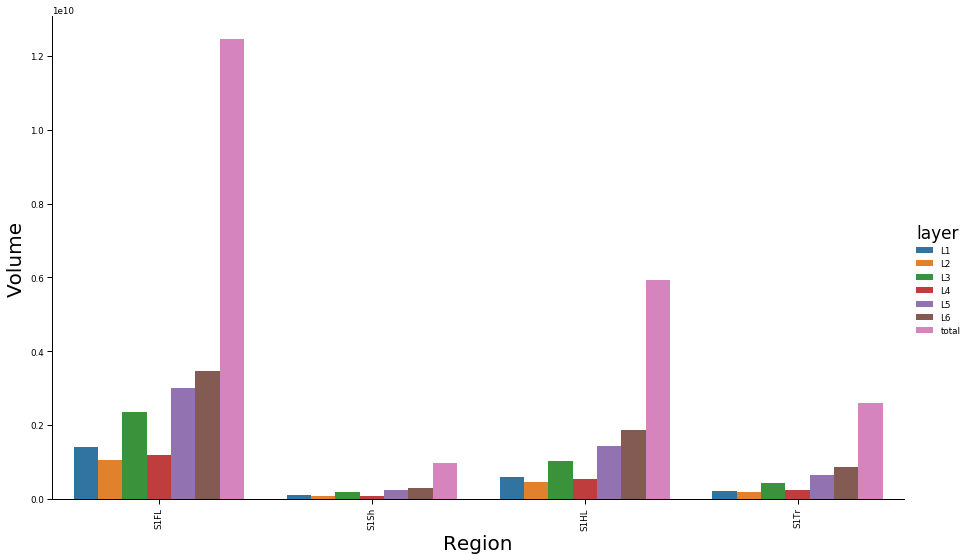

In [13]:
report_volumes = analysis_region_volumes(circuit_model, adapter)

In [16]:
reload(rp)
reporter =\
    rp.CheetahReporter(
        path_output_folder=os.path.join(
            spec.path_reports, "analyses"))
reporter.post(report_volumes)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
DEBUGINFO@<2020-03-06 15:41:52>                                                 
.post(report=<neuro_dmt.analysis.reporting.CircuitAnalysisReport object at 0x14e4a34d0>,
                   template=None,
                   path_output_folder=None,
                   output_subfolder=None,
                   report_file_name=report.html,
                   strict=False,
                   with_time_stamp=True,
                   path_main_report=None,
                   title_main_report=None,
                   section_index=None,
                   chapter_index=None)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-06 15:41:52>                                                      
Post report volume at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/s

'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/volume/20200306/154856'

### Layer Thickness

Layer thickness is tricky to define for an atlas based circuit.
We expect that for a given sub-region a sample of layer thicknesses can be drawn.
Our next analysis uses this technique and plots the distribution of drawn samples
for each sub-region.

In [70]:
def measurement_thickness(
        adapter, circuit_model,
        region=None,
        **kwargs):
    """
    Measure layer thickness in the given region.
    """
    wide = adapter.get_layer_thickness_values(circuit_model, region=region)
    wide.columns.name = "layer"
    return\
        pd.concat([wide.iloc[i] for i in range(wide.shape[0])])\
          .rename("thickness")

In [96]:
phenomenon["thickness"] =\
    Phenomenon(
        "Thickness",
        description="Thickness of layers.",
        group="Composition")

analysis_layer_thickness =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["thickness"],
        introduction="""
        Thickness of layers measured in each region modeled in the circuit.
        """,
        methods="""
        Thickness of layers were measured as the shortest top-bottom line
        passing through each voxel in the voxelized space.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions),
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        sample_measurement=measurement_thickness,
        measurement_collection=measurement.collection.series_type,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="thickness",
                     ylabel="Thickness",
                     gvar="layer"),
        report=CircuitAnalysisReport)





  0%|          | 0/4 [00:00<?, ?it/s]



 25%|██▌       | 1/4 [00:24<01:12, 24.28s/it]



 50%|█████     | 2/4 [00:50<00:49, 24.99s/it]



 75%|███████▌  | 3/4 [01:13<00:24, 24.37s/it]



100%|██████████| 4/4 [01:37<00:00, 24.27s/it]


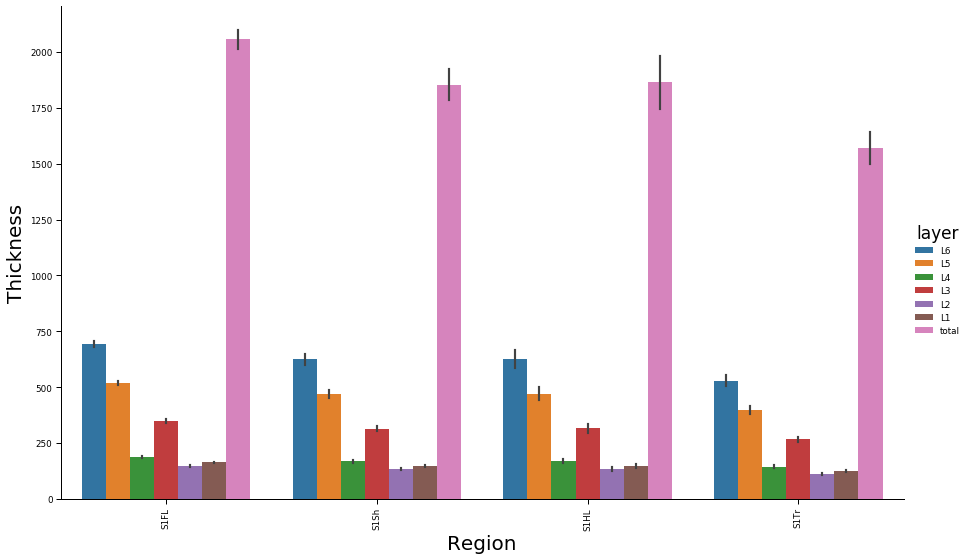

In [97]:
report_thickness =\
    analysis_layer_thickness(circuit_model, adapter)

In [98]:
reporter.post(report_thickness)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
.post(report=<neuro_dmt.analysis.reporting.CircuitAnalysisReport object at 0x19b46dcd0>,
                   template=None,
                   path_output_folder=None,
                   output_subfolder=None,
                   report_file_name=report.html,
                   strict=False,
                   with_time_stamp=True,
                   path_main_report=None,
                   title_main_report=None,
                   section_index=None,
                   chapter_index=None)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-06 15:56:00>                                                      
Post report thickness at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visoo

'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/thickness/20200306/175218'

## Cell Distribution

In this section we study the distribution of cells over the physical geometry
of the circuit.


In [12]:
def random_position(
        adapter, circuit_model,
        **query):
    """
    Random position in circuit region specified by `query`.
    """
    spatial_query = terminology.circuit.get_spatial_query(query)
    return adapter.random_position(circuit_model, **spatial_query)
    
def random_box(
        adapter, circuit_model, 
        size_roi=100., **query):
    """
    Random cuboid in circuit region specified by `query`.
    """
    position = random_position(adapter, circuit_model, **query)
    return Cuboid(position - size_roi, position + size_roi)\
        if position is not None else None

def measurement_cell_count_using_sampling(
        adapter, circuit_model,
        size_roi=100., **query):
    """
    Measure the number of cells in a spatial location specified by the query.
    """
    box = random_box(adapter, circuit_model, size_roi=size_roi, **query)
    return adapter.get_cells(circuit_model, roi=box).shape[0]\
        if box is not None else 0.

### Cell Count

Circuit regions and layers are not the same size, and contain different densities
of cells.

In [108]:
phenomenon["cell_count"] =\
    Phenomenon("Cell Count", 
               description="Number of cells in the circuit.",
               group="Composition")
    
analysis_cell_count =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["cell_count"],
        introduction="""
        Number of cells in each of the populated sub-regions are analyzed.
        """,
        methods="""
        Cells were counted in randomly sampled cubic boxes of side $size_roi.
        Each sampled box was conditioned to lie in the spatial location 
        specified by brain-region and layer queried. For each spatial query,
        the measured sample contained $sample_size boxes.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers),
        sample_measurement=measurement_cell_count_using_sampling,
        sample_size=20,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="cell_count",
                     ylabel="Cell Count",
                     gvar="layer"),
        report=CircuitAnalysisReport)
                                       






  0%|          | 0/480 [00:00<?, ?it/s]




  1%|          | 3/480 [00:00<00:19, 24.31it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x153113c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x153113c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19620f090>}

/Users/vi






  1%|▏         | 6/480 [00:00<00:20, 23.04it/s]




  2%|▏         | 9/480 [00:00<00:19, 24.48it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ebc8c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ebc8c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa26cd0>}

/Users/vi






  2%|▎         | 12/480 [00:00<00:18, 25.04it/s]




  3%|▎         | 15/480 [00:00<00:18, 25.63it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1989c5dd0>}

/Users/vi






  4%|▍         | 18/480 [00:00<00:17, 26.61it/s]




  4%|▍         | 21/480 [00:00<00:17, 26.39it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec98410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec98410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ebc8910>}

/Users/vi






  5%|▌         | 24/480 [00:00<00:18, 24.87it/s]




  6%|▌         | 27/480 [00:01<00:18, 24.52it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa26b10>}

/Users/vi






  6%|▋         | 30/480 [00:01<00:18, 24.01it/s]




  7%|▋         | 33/480 [00:01<00:18, 23.98it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa26110>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa26110>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17eba7c10>}

/Users/vi






  8%|▊         | 36/480 [00:01<00:18, 23.72it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b690>}

/Users/vi






  8%|▊         | 39/480 [00:01<00:18, 23.65it/s]




  9%|▉         | 42/480 [00:01<00:19, 22.50it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1989c56d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1989c56d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1989c56d0>}

/Users/vi






  9%|▉         | 45/480 [00:01<00:19, 22.18it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ecc4810>}

/Users/vi






 10%|█         | 48/480 [00:02<00:20, 20.99it/s]




 11%|█         | 51/480 [00:02<00:19, 21.63it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec98d90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec98d90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180682950>}

/Users/vi






 11%|█▏        | 54/480 [00:02<00:19, 21.50it/s]




 12%|█▏        | 57/480 [00:02<00:20, 20.95it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9be210>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9be210>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497bbd0>}

/Users/vi






 12%|█▎        | 60/480 [00:02<00:20, 20.79it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806825d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806825d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806825d0>}

/Users/vi






 13%|█▎        | 63/480 [00:02<00:20, 20.61it/s]




 14%|█▍        | 66/480 [00:02<00:19, 21.05it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497bd50>}

/Users/vi






 14%|█▍        | 69/480 [00:03<00:20, 20.29it/s]




 15%|█▌        | 72/480 [00:03<00:19, 20.83it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1989c5cd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1989c5cd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005790>}

/Users/vi






 16%|█▌        | 75/480 [00:03<00:19, 20.91it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa264d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa264d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180682450>}

/Users/vi






 16%|█▋        | 78/480 [00:03<00:18, 21.51it/s]




 17%|█▋        | 81/480 [00:03<00:18, 21.55it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9be190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9be190>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9be690>}

/Users/vi






 18%|█▊        | 84/480 [00:03<00:18, 21.05it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005790>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005790>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa26110>}

/Users/vi






 18%|█▊        | 87/480 [00:03<00:19, 20.11it/s]




 19%|█▉        | 90/480 [00:04<00:19, 19.79it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497ba90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497ba90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9bef10>}

/Users/vi






 19%|█▉        | 93/480 [00:04<00:18, 20.50it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9be690>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9be690>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fa050>}

/Users/vi






 20%|██        | 96/480 [00:04<00:18, 20.59it/s]




 21%|██        | 99/480 [00:04<00:18, 20.74it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fac10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fac10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fac10>}

/Users/vi






 21%|██▏       | 102/480 [00:04<00:18, 20.83it/s]




 22%|██▏       | 105/480 [00:04<00:17, 21.43it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be7cbd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be7cbd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be7cbd0>}

/Users/vi






 22%|██▎       | 108/480 [00:04<00:18, 20.56it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9bec50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9bec50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9bedd0>}

/Users/vi






 23%|██▎       | 111/480 [00:05<00:17, 21.01it/s]




 24%|██▍       | 114/480 [00:05<00:17, 20.60it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f5050>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f5050>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f5890>}

/Users/vi






 24%|██▍       | 117/480 [00:05<00:16, 21.45it/s]




 25%|██▌       | 120/480 [00:05<00:16, 21.59it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9bedd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9bedd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fa710>}

/Users/vi






 26%|██▌       | 123/480 [00:05<00:15, 22.44it/s]




 26%|██▋       | 126/480 [00:05<00:14, 24.21it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005150>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9bea10>}

/Users/vi






 27%|██▋       | 129/480 [00:05<00:14, 24.82it/s]




 28%|██▊       | 132/480 [00:05<00:14, 24.55it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec98890>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec98890>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec98890>}

/Users/vi






 28%|██▊       | 135/480 [00:06<00:13, 25.81it/s]




 29%|██▉       | 139/480 [00:06<00:12, 27.44it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fa250>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fa250>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f5f10>}

/Users/vi






 30%|██▉       | 142/480 [00:06<00:12, 27.19it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180682750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180682750>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005310>}

/Users/vi






 30%|███       | 145/480 [00:06<00:14, 22.94it/s]




 31%|███       | 148/480 [00:06<00:15, 21.68it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955650>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955650>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955d90>}

/Users/vi






 31%|███▏      | 151/480 [00:06<00:15, 21.74it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955350>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955350>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9be810>}

/Users/vi






 32%|███▏      | 154/480 [00:06<00:15, 20.67it/s]




 33%|███▎      | 157/480 [00:07<00:15, 20.48it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fa310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fa310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be7c510>}

/Users/vi






 33%|███▎      | 160/480 [00:07<00:15, 21.32it/s]




 34%|███▍      | 163/480 [00:07<00:14, 21.68it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f50d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f50d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fac50>}

/Users/vi






 35%|███▍      | 166/480 [00:07<00:14, 22.17it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497bb10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497bb10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005c50>}

/Users/vi






 35%|███▌      | 169/480 [00:07<00:14, 21.66it/s]




 36%|███▌      | 172/480 [00:07<00:14, 21.34it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955510>}

/Users/vi






 36%|███▋      | 175/480 [00:07<00:13, 21.81it/s]




 37%|███▋      | 178/480 [00:08<00:13, 22.13it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be57210>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be57210>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be57f10>}

/Users/vi






 38%|███▊      | 181/480 [00:08<00:13, 22.25it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa01790>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa01790>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa01d90>}

/Users/vi






 38%|███▊      | 184/480 [00:08<00:13, 22.44it/s]




 39%|███▉      | 187/480 [00:08<00:12, 22.81it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497bb10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497bb10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497bb10>}

/Users/vi






 40%|███▉      | 190/480 [00:08<00:12, 23.00it/s]




 40%|████      | 193/480 [00:08<00:12, 23.69it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19a7f23d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19a7f23d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b190>}

/Users/vi






 41%|████      | 196/480 [00:08<00:12, 23.53it/s]




 41%|████▏     | 199/480 [00:08<00:12, 22.53it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955dd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955dd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1599550d0>}

/Users/vi






 42%|████▏     | 202/480 [00:09<00:12, 22.98it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1e90>}

/Users/vi






 43%|████▎     | 205/480 [00:09<00:11, 23.24it/s]




 43%|████▎     | 208/480 [00:09<00:11, 23.73it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1f10>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1f10>}

/Users/vi






 44%|████▍     | 211/480 [00:09<00:11, 23.85it/s]




 45%|████▍     | 214/480 [00:09<00:11, 23.59it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c3fa6d0>}

/Users/vi






 45%|████▌     | 217/480 [00:09<00:10, 24.44it/s]




 46%|████▌     | 220/480 [00:09<00:10, 24.19it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f5950>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f5950>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be7c510>}

/Users/vi






 46%|████▋     | 223/480 [00:09<00:10, 23.50it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be57310>}

/Users/vi






 47%|████▋     | 226/480 [00:10<00:10, 23.75it/s]




 48%|████▊     | 229/480 [00:10<00:10, 23.29it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1bd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1bd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1bd0>}

/Users/vi






 48%|████▊     | 232/480 [00:10<00:11, 22.19it/s]




 49%|████▉     | 235/480 [00:10<00:11, 21.97it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031250>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031250>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa01e10>}

/Users/vi






 50%|████▉     | 238/480 [00:10<00:11, 21.44it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b3d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b3d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1599557d0>}

/Users/vi






 50%|█████     | 241/480 [00:10<00:10, 22.21it/s]




 51%|█████     | 244/480 [00:10<00:10, 23.28it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198941350>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198941350>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198941050>}

/Users/vi






 51%|█████▏    | 247/480 [00:10<00:09, 24.48it/s]




 52%|█████▏    | 250/480 [00:11<00:09, 25.15it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198941850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198941850>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1599557d0>}

/Users/vi






 53%|█████▎    | 254/480 [00:11<00:08, 26.48it/s]




 54%|█████▎    | 257/480 [00:11<00:08, 26.66it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec979d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec979d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031510>}

/Users/vi






 54%|█████▍    | 261/480 [00:11<00:07, 27.41it/s]




 55%|█████▌    | 264/480 [00:11<00:08, 24.80it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1dd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1dd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1f10>}

/Users/vi






 56%|█████▌    | 267/480 [00:11<00:08, 24.59it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198941290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198941290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198103e10>}

/Users/vi






 56%|█████▋    | 270/480 [00:11<00:09, 23.10it/s]




 57%|█████▋    | 273/480 [00:11<00:08, 23.77it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198103390>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198103390>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec97690>}

/Users/vi






 57%|█████▊    | 276/480 [00:12<00:09, 21.55it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031310>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031310>}

/Users/vi






 58%|█████▊    | 279/480 [00:12<00:09, 21.27it/s]




 59%|█████▉    | 282/480 [00:12<00:09, 21.56it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955990>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x159955990>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1590>}

/Users/vi






 59%|█████▉    | 285/480 [00:12<00:09, 21.35it/s]




 60%|██████    | 288/480 [00:12<00:08, 21.55it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be57590>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19be57590>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa26cd0>}

/Users/vi






 61%|██████    | 291/480 [00:12<00:08, 21.24it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031250>}

/Users/vi






 61%|██████▏   | 294/480 [00:12<00:08, 21.57it/s]




 62%|██████▏   | 297/480 [00:13<00:08, 21.60it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596d90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596d90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15497b290>}

/Users/vi






 62%|██████▎   | 300/480 [00:13<00:08, 21.77it/s]




 63%|██████▎   | 303/480 [00:13<00:07, 22.26it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031710>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031710>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198941510>}

/Users/vi






 64%|██████▍   | 306/480 [00:13<00:07, 22.65it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1980fa890>}

/Users/vi






 64%|██████▍   | 309/480 [00:13<00:07, 22.14it/s]




 65%|██████▌   | 312/480 [00:13<00:07, 22.75it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596090>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596090>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596110>}

/Users/vi






 66%|██████▌   | 315/480 [00:13<00:07, 22.82it/s]




 66%|██████▋   | 318/480 [00:14<00:07, 22.95it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031110>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15c031110>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec97750>}

/Users/vi






 67%|██████▋   | 321/480 [00:14<00:06, 23.11it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1980fa810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1980fa810>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15bc7b810>}

/Users/vi






 68%|██████▊   | 324/480 [00:14<00:06, 22.56it/s]




 68%|██████▊   | 327/480 [00:14<00:06, 22.89it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19811a050>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19811a050>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19811a050>}

/Users/vi






 69%|██████▉   | 330/480 [00:14<00:06, 22.64it/s]




 69%|██████▉   | 333/480 [00:14<00:06, 23.46it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005c50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1d50>}

/Users/vi






 70%|███████   | 336/480 [00:14<00:06, 22.99it/s]




 71%|███████   | 339/480 [00:14<00:06, 23.40it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bf410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bf410>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1980faa90>}

/Users/vi






 71%|███████▏  | 342/480 [00:15<00:05, 23.61it/s]






/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x152fe8c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x152fe8c90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15fa26cd0>}

/Users/vi

 72%|███████▏  | 345/480 [00:15<00:05, 23.72it/s]




 72%|███████▎  | 348/480 [00:15<00:05, 22.98it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1980fa910>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1980fa910>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15bc7b0d0>}

/Users/vi






 73%|███████▎  | 351/480 [00:15<00:05, 23.33it/s]




 74%|███████▍  | 354/480 [00:15<00:05, 23.45it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec976d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec976d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec976d0>}

/Users/vi






 74%|███████▍  | 357/480 [00:15<00:05, 23.40it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bf8d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bf8d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bf490>}

/Users/vi






 75%|███████▌  | 360/480 [00:15<00:05, 22.31it/s]




 76%|███████▌  | 363/480 [00:15<00:04, 23.77it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bf290>}

/Users/vi






 76%|███████▋  | 367/480 [00:16<00:04, 25.90it/s]




 77%|███████▋  | 371/480 [00:16<00:03, 28.25it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec97b50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec97b50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec97b50>}

/Users/vi






 78%|███████▊  | 375/480 [00:16<00:03, 29.49it/s]




 79%|███████▉  | 379/480 [00:16<00:03, 30.02it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198103510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x198103510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x168df1c10>}

/Users/vi






 80%|███████▉  | 383/480 [00:16<00:03, 27.96it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x155108e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x155108e90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4790>}

/Users/vi






 80%|████████  | 386/480 [00:16<00:03, 26.31it/s]




 81%|████████  | 389/480 [00:16<00:03, 25.12it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1550f6550>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1550f6550>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4350>}

/Users/vi






 82%|████████▏ | 392/480 [00:17<00:03, 24.53it/s]




 82%|████████▏ | 395/480 [00:17<00:03, 24.23it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f53d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1530f53d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15bc7b390>}

/Users/vi






 83%|████████▎ | 398/480 [00:17<00:03, 23.85it/s]






/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x155108f50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x155108f50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x155108f50>}

/Users/vi

 84%|████████▎ | 401/480 [00:17<00:03, 24.25it/s]




 84%|████████▍ | 404/480 [00:17<00:03, 23.98it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec97610>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec97610>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ec97610>}

/Users/vi






 85%|████████▍ | 407/480 [00:17<00:03, 23.83it/s]




 85%|████████▌ | 410/480 [00:17<00:03, 22.83it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4510>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1550f6410>}

/Users/vi






 86%|████████▌ | 413/480 [00:17<00:02, 23.22it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b3d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b3d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b950>}

/Users/vi






 87%|████████▋ | 416/480 [00:18<00:02, 23.33it/s]




 87%|████████▋ | 419/480 [00:18<00:02, 23.70it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4b50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4b50>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b790>}

/Users/vi






 88%|████████▊ | 422/480 [00:18<00:02, 24.04it/s]




 89%|████████▊ | 425/480 [00:18<00:02, 24.13it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bfa90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bfa90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b3d0>}

/Users/vi






 89%|████████▉ | 428/480 [00:18<00:02, 23.31it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ebb3590>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ebb3590>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b005c50>}

/Users/vi






 90%|████████▉ | 431/480 [00:18<00:02, 23.55it/s]




 90%|█████████ | 434/480 [00:18<00:01, 23.61it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1551087d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1551087d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f4350>}

/Users/vi






 91%|█████████ | 437/480 [00:18<00:01, 23.23it/s]




 92%|█████████▏| 440/480 [00:19<00:01, 23.23it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596290>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b590>}

/Users/vi






 92%|█████████▏| 443/480 [00:19<00:01, 23.08it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15bc7b890>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15bc7b890>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1806bfd10>}

/Users/vi






 93%|█████████▎| 446/480 [00:19<00:01, 23.38it/s]




 94%|█████████▎| 449/480 [00:19<00:01, 23.59it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b490>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b4d0>}

/Users/vi






 94%|█████████▍| 452/480 [00:19<00:01, 23.79it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ebb3d90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17ebb3d90>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b550>}

/Users/vi






 95%|█████████▍| 455/480 [00:19<00:01, 21.50it/s]




 95%|█████████▌| 458/480 [00:19<00:01, 21.53it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1989412d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x1989412d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x15bc7b150>}

/Users/vi






 96%|█████████▌| 461/480 [00:20<00:00, 21.08it/s]




 97%|█████████▋| 464/480 [00:20<00:00, 22.27it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596910>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x180596910>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b1d0>}

/Users/vi






 97%|█████████▋| 467/480 [00:20<00:00, 21.92it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9c3350>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9c3350>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x17e9c3350>}

/Users/vi






 98%|█████████▊| 470/480 [00:20<00:00, 22.41it/s]




 99%|█████████▊| 473/480 [00:20<00:00, 22.58it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f47d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x19b6f47d0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x152fd4c10>}

/Users/vi






 99%|█████████▉| 476/480 [00:20<00:00, 22.24it/s]




100%|█████████▉| 479/480 [00:20<00:00, 22.03it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066bcd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066bcd0>}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x18066b250>}

/Users/vi

100%|██████████| 480/480 [00:20<00:00, 22.99it/s]


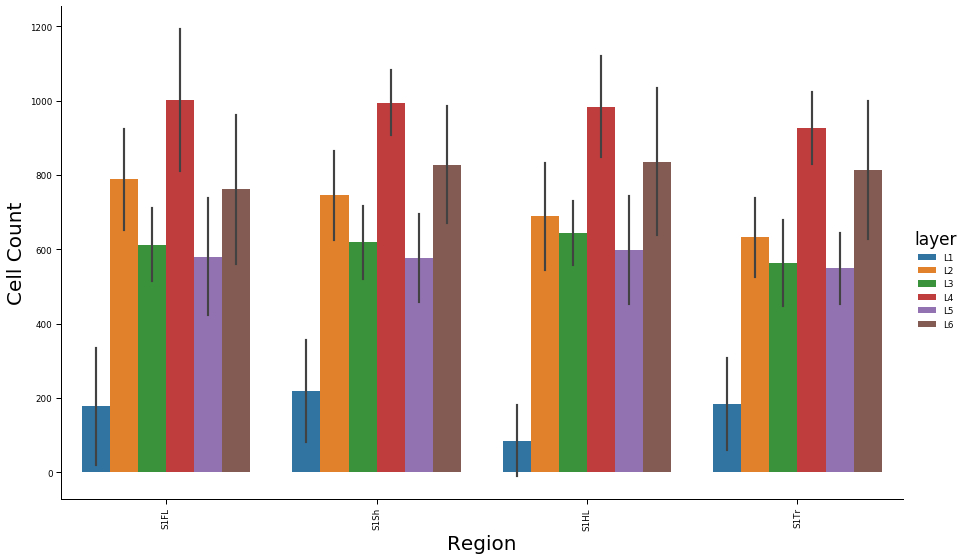

In [109]:
report_cell_count =\
    analysis_cell_count(circuit_model, adapter)

In [110]:
reporter.post(report_cell_count)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
.post(report=<neuro_dmt.analysis.reporting.CircuitAnalysisReport object at 0x19be57f10>,
                   template=None,
                   path_output_folder=None,
                   output_subfolder=None,
                   report_file_name=report.html,
                   strict=False,
                   with_time_stamp=True,
                   path_main_report=None,
                   title_main_report=None,
                   section_index=None,
                   chapter_index=None)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-06 15:56:00>                                                      
Post report cell_count at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/viso

'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/cell_count/20200306/183132'

### Mtype Cell Counts

We can also count cells in each region, layer by mtype.

In [29]:
phenomenon["mtype_cell_count"] =\
    Phenomenon("Mtype Cell Count", 
               description="Number of cells in the circuit.",
               group="Composition")
    
def measurement_mtype_cell_count_using_sampling(
        adapter, circuit_model,
        size_roi=100., **query):
    """
    Measure the number of cells in a spatial location specified by the query.
    """
    box =\
        random_box(adapter, circuit_model, size_roi=size_roi, **query)
    if box is None:
        return pd.Series()
    cells = adapter.get_cells(circuit_model, roi=box)
    return cells.groupby("mtype").agg("size")

def measurement_mtype_cell_count_exhaustive(
        adapter, circuit_model,
        sampling_methodology=None,
        **query):
    """
    ...
    """
    cells =\
        adapter.get_cells(circuit_model, **query)
    return\
        cells.groupby("mtype").agg("size")

analysis_mtype_cell_count =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["mtype_cell_count"],
        introduction="""
        Number of cells in each of the populated sub-regions are analyzed.
        """,
        methods="""
        Cells were counted in randomly sampled cubic boxes of side $size_roi.
        Each sampled box was conditioned to lie in the spatial location 
        specified by brain-region and layer queried. For each spatial query,
        the measured sample contained $sample_size boxes.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers),
        sample_measurement=measurement_mtype_cell_count_exhaustive,
        sample_size=1,
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        measurement_collection=measurement.collection.series_type,
        plotter=MultiPlot(
            mvar="mtype",
            plotter=Bars(xvar="region",
                         xlabel="Region",
                         yvar="mtype_cell_count",
                         ylabel="Cell Count",
                         gvar="layer")),
        report=CircuitAnalysisReport)
                                       

In [30]:
report_mtype_cell_counts =\
    analysis_mtype_cell_count(circuit_model, adapter)







  0%|          | 0/24 [00:00<?, ?it/s]

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 22:57:40>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L1'}



KeyError: <neuro_dmt.models.bluebrain.circuit.adapter.adapter.BlueBrainCircuitAdapter object at 0x7fba7d581c18>

### Cell Density

The number of cells in an volume specified by a region and layer is determined 
by the size of volume.
We can take out the volume by analyzing cell densities.

In [102]:
def measurement_cell_density_using_sampling(
        adapter, circuit_model,
        size_roi=100., **query):
    """
    Measure the density of cells in a spatial location specified by the query.
    """
    box = random_box(adapter, circuit_model, size_roi=size_roi, **query)
    
    if box is None:
        return 0.
    count_cells = adapter.get_cells(circuit_model, roi=box).shape[0]
    volume_spatial = box.volume
    return count_cells / volume_spatial

In [103]:
phenomenon["cell_density"] =\
    Phenomenon("Cell Density", 
               description="Number of cells in a unit volume.",
               group="Composition")
    
analysis_cell_density =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["cell_density"],
        introduction="""
        Density of cells in each of the populated sub-regions are analyzed.
        """,
        methods="""
        Cells were counted in randomly sampled cubic boxes of side $size_roi.
        Each sampled box was conditioned to lie in the spatial location 
        specified by brain-region and layer queried. For each spatial query,
        the measured sample contained $sample_size boxes.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers),
        sample_measurement=measurement_cell_density_using_sampling,
        sample_size=20,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="cell_density",
                     ylabel="Cell Density",
                     gvar="region"),
        report=CircuitAnalysisReport)

In [104]:
report_cell_density = analysis_cell_density(circuit_model, adapter)





  0%|          | 0/480 [00:00<?, ?it/s]

NameError: name 'random_box' is not defined

In [59]:
reporter.post(report_cell_density)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-05 12:29:15>                                                      
Post report cell_density at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/cell_density/20200305/144025



'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/cell_density/20200305/144025'

# Connectome

The connectome of a circuit consists of synapses between the cells.

## Efferent connections of cells 

An efferent connection is an outgoing connection,
and the cell in question the pre-synaptic cell.
We have developed to make connectome measurements on the circuit.
We use this tool to define a measurement of efferent degree.

In [201]:
reload(pm)
efferent_degree =\
    pm.PathwayMeasurement(
        direction="EFF",
        value=lambda connections: 1.,
        variable="number_connections_efferent",
        specifiers_cell_type=["mtype"],
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        sample_size=100,
        processing_methodology=terminology.processing_methodology.batch,
        batch_size=1000)

In [203]:
effdeg_serial =\
    pm.PathwayMeasurement(
        direction="EFF",
        value = lambda connections: 1,
        variable="number_connections_efferent",
        specifiers_cell_type=["mtype"],
        sampling_methodology=terminology.sampling_methodology.random,
        sample_size=10,
        processing_methodology=terminology.processing_methodology.serial,
        return_primary_info=True)

In [204]:
sample_effdeg =\
    effdeg_serial.sample(
        circuit_model, adapter)

In [207]:
se1 = next(sample_effdeg)

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
Traceback:
	filename: 	/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	630
	code_context: 	['            LOGGER.get_source_info(),\n']
	index: 0

PathwayMeasurement._method(...)
number primary.target 16
number secondary.target 1913723

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
PathwayMeasurement.get_connections(...)
queried primary gids 1
queried secondary gids 1913723

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py

In [219]:
se1[np.logical_not(pd.isna(se1).values)].sum()

number_connections_efferent    275.0
dtype: float64

In [142]:
affdeg_serial =\
    pm.PathwayMeasurement(
        direction="AFF",
        value = lambda connections: 1,
        variable="number_connections_afferent",
        specifiers_cell_type=["mtype"],
        sampling_methodology=terminology.sampling_methodology.random,
        sample_size=10,
        processing_methodology=terminology.processing_methodology.serial,
        return_primary_info=True)

In [143]:
sample_affdeg =\
    affdeg_serial.sample(
        circuit_model, adapter)
sa1 = next(sample_affdeg)

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
PathwayMeasurement.sample(...)
with sampling methodology random

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
PathwayMeasurement._sample_target(...)
{'direction': 'AFF', 'post_synaptic_cell_group': {}, 'pre_synaptic_cell_group': {}}

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
Adapter get cells for query: 
target None
{}

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-08 11:57:33>

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
PathwayMeasurement get_connections
queried gids 1
number connections: 841

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
Adapter get cells for query: 
target None
{}

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
Model get cells for query
{}

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
Traceback:
	filename: 	/home/muchu

In [145]:
gids_primary = sa1.reset_index()[("post_synaptic_cell", "gid")]
sa1.head()

(pre_synaptic_cell, mtype)  (post_synaptic_cell, gid)
L1_DAC                      440096                      NaN
L1_HAC                      440096                      NaN
L1_LAC                      440096                      NaN
L1_NGC-DA                   440096                      NaN
L1_NGC-SA                   440096                      NaN
Name: number_connections_afferent, dtype: float64

In [169]:
cells = adapter.get_cells(circuit_model)
specifiers_primary =\
    cells.iloc[gids_primary][affdeg_serial.specifiers_cell_type]
specifiers_secondary =\
    sa1.reset_index()[("pre_synaptic_cell", "mtype")]
specifiers_secondary.name = "mtype"
print(specifiers_primary.reset_index(drop=True).head())
print(specifiers_secondary.reset_index(drop=True).head())
pd.concat(
    [specifiers_primary.reset_index(drop=True),
     specifiers_secondary.reset_index(drop=True)],
    axis=1,
    keys=[("post"), ("pre")])\
  .assign(**{affdeg_serial.variable: sa1.values})\
  .set_index()

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
Adapter get cells for query: 
target None
{}

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
Model get cells for query
{}

    mtype
0  L6_UPC
1  L6_UPC
2  L6_UPC
3  L6_UPC
4  L6_UPC
0       L1_DAC
1       L1_HAC
2       L1_LAC
3    L1_NGC-DA
4    L1_NGC-SA
Name: mtype, dtype: category
Categories (60, object): [L1_DAC, L1_HAC, L1_LAC, L1_NGC-DA, ..., L6_SBC, L6_TPC:A, L6_TPC:C, L6_UPC]


,post,pre,number_connections_afferent
,mtype,mtype,
0,L6_UPC,L1_DAC,NaN
1,L6_UPC,L1_HAC,NaN
2,L6_UPC,L1_LAC,NaN
3,L6_UPC,L1_NGC-DA,NaN
4,L6_UPC,L1_NGC-SA,NaN
5,L6_UPC,L1_SAC,NaN
6,L6_UPC,L23_BP,NaN
7,L6_UPC,L23_BTC,NaN
8,L6_UPC,L23_CHC,NaN


In [34]:
effdeg_batch =\
    pm.PathwayMeasurement(
        direction="EFF",
        value = lambda connections: 1,
        variable="number_connections_efferent",
        specifiers_cell_type=["mtype"],
        sampling_methodology=terminology.sampling_methodology.random,
        sample_size=10,
        processing_methodology=terminology.processing_methodology.batch,
        batch_size=10)

In [35]:
sample_effdeg_batch =\
    effdeg_batch.sample(
        circuit_model, adapter)

In [36]:

seb1 = next(sample_effdeg_batch)

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
PathwayMeasurement.sample(...)
with sampling methodology random

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
PathwayMeasurement._sample_target(...)
{'direction': 'EFF', 'post_synaptic_cell_group': {}, 'pre_synaptic_cell_group': {}}

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
Adapter get cells for query: 
target None
{}

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-08 11:57:33>

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
PathwayMeasurement get_connections
queried gids 10
number connections: 4399

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
Adapter get cells for query: 
target None
{}

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
Model get cells for query
{}

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
Traceback:
	filename: 	/home/muc

In [45]:
seb1.groupby(("post_synaptic_cell", "mtype")).agg(effdeg_batch.summaries).head()

,count,sum,mean,mad,std,var,min,median,max
"(post_synaptic_cell, mtype)",,,,,,,,,
L1_DAC,1,3.0,3.0,0.0,NaN,NaN,3.0,3.0,3.0
L1_HAC,2,5.0,2.5,1.5,2.12132,4.5,1.0,2.5,4.0
L1_LAC,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L1_NGC-DA,1,2.0,2.0,0.0,NaN,NaN,2.0,2.0,2.0
L1_NGC-SA,1,1.0,1.0,0.0,NaN,NaN,1.0,1.0,1.0


In [46]:
seb1.shape

(600,)

In [47]:
for mtype in adapter.get_mtypes(circuit_model):
    

In [48]:
mtypes

[L1_DAC, L3_TPC:A, L23_LBC, L23_BTC, L23_NGC, ..., L5_TPC:B, L5_TPC:A, L5_NGC, L5_MC, L5_BP]
Length: 60
Categories (60, object): [L1_DAC, L3_TPC:A, L23_LBC, L23_BTC, ..., L5_TPC:A, L5_NGC, L5_MC, L5_BP]